# COVID Forecasting Review Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (20,8)

## Load and clean data

In [3]:
data = pd.read_csv("../data/finaldata.csv", keep_default_na=False)
data

,title,doi,performance_eval,performance_eval_sub,reader,data_cat,method_cat,forecasting_window,forecasting_window_sub,region_level,target,metrics,uncertainty_sub,uncertainty,limitations
0,A Mass-Conservation Model for Stability Analys...,10.1109/TCSS.2021.3050476,not evaluable,not evaluable,Felix,"cases, deaths",compartmental,Long-term,,national,"cases, deaths",NA,no,no,none
1,A Novel Intelligent Computational Approach to ...,10.1109/JBHI.2020.3027987,not evaluable,not evaluable,Felix,cases,statistical,Long-term,Interventions,national,cases,NA,95% CIs,CIs/PIs,"data, unknown factors that affect covid outcomes"
2,A SIR model assumption for the spread of COVID...,10.1016/j.chaos.2020.110057,not evaluable,not evaluable,Felix,"cases, deaths",compartmental,Long-term,,national,cases,NA,no,no,none
3,A SIR-type model describing the successive wav...,10.1016/j.chaos.2021.110682,not evaluable,not evaluable,Felix,"cases, deaths",compartmental,Long-term,,national,"cases, deaths",NA,no,no,none
4,A Spatiotemporal Tool to Project Hospital Crit...,10.2105/AJPH.2021.306220,not evaluable,not evaluable,Felix,"cases, mobility, hospitalizations",compartmental,Long-term,"Scenarios, Interventions",national,cases,NA,no,no,"data, limitations specific to the methods used..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,Time series prediction of COVID-19 transmissio...,10.1016/j.rinp.2021.104462,metric-based,compare internally,Sonia,cases,statistical,Short-term,,national,cases,"MAE, MSE, RMSE, MAPE",no,no,note factors that were not accounted for in th...
133,Time-dependent heterogeneity leads to transien...,10.1073/PNAS.2015972118,not evaluable,not evaluable,Sonia,"deaths, hospitalizations",hybrid,Long-term,,city,deaths,NA,95% CIs,CIs/PIs,note factors that were not accounted for in th...
134,Time-variant reliability-based prediction of C...,10.1016/j.rinp.2021.104364,not evaluable,not evaluable,further discussion,"cases, deaths",compartmental,Long-term,"Scenarios, Interventions",national,"cases, deaths, curves of probabilities that ca...",NA,exceedance probabilities (prob that true value...,CIs/PIs,unknown factors that affect covid outcomes
135,Timing social distancing to avert unmanageable...,10.1073/PNAS.2009033117,not evaluable,not evaluable,Sonia,"hospitalizations, policy, human behavior",compartmental,Long-term,"Scenarios, Interventions",city,"hospitalizations, deaths",NA,90% prediction interval based on 300 simulations,CIs/PIs,"limited generalizability, note factors that we..."


In [4]:
metadata = pd.read_csv("../data/metadata.csv", keep_default_na=True, parse_dates=["date_published"])

In [5]:
journal_metadata = pd.read_csv("../data/journal_metadata.csv")
journal_subjects_lookup = {row[1].title: row[1].subjects for row in journal_metadata.iterrows()}
metadata["journal_subjects"] = metadata.journal.map(lambda x: journal_subjects_lookup.get(x, ""))
metadata.loc[metadata.paper_type != "journal-article", "journal_subjects"] = "preprint"

In [6]:
metadata

,title,doi,date_published,date_published_print,journal,publisher,citations,paper_type,n_authors,journal_subjects
0,A Mass-Conservation Model for Stability Analys...,10.1109/TCSS.2021.3050476,2021-02-03 05:47:36+00:00,2021-8,IEEE Transactions on Computational Social Systems,Institute of Electrical and Electronics Engine...,1.0,journal-article,2.0,Human-Computer Interaction; Social Sciences (m...
1,A Novel Intelligent Computational Approach to ...,10.1109/JBHI.2020.3027987,2020-09-30 20:09:12+00:00,2020-12,IEEE Journal of Biomedical and Health Informatics,Institute of Electrical and Electronics Engine...,5.0,journal-article,12.0,Health Information Management; Electrical and ...
2,A SIR model assumption for the spread of COVID...,10.1016/j.chaos.2020.110057,2020-06-28 07:50:11+00:00,2020-10,"Chaos, Solitons & Fractals",Elsevier BV,160.0,journal-article,3.0,General Mathematics; General Physics and Astro...
3,A SIR-type model describing the successive wav...,10.1016/j.chaos.2021.110682,2021-01-15 03:07:04+00:00,2021-3,"Chaos, Solitons & Fractals",Elsevier BV,6.0,journal-article,3.0,General Mathematics; General Physics and Astro...
4,A Spatiotemporal Tool to Project Hospital Crit...,10.2105/AJPH.2021.306220,2021-04-15 20:02:20+00:00,2021-6,American Journal of Public Health,American Public Health Association,3.0,journal-article,12.0,"Public Health, Environmental and Occupational ..."
...,...,...,...,...,...,...,...,...,...,...
132,Time-dependent heterogeneity leads to transien...,10.1073/PNAS.2015972118,2021-04-08 20:00:40+00:00,2021-4-27,Proceedings of the National Academy of Sciences,Proceedings of the National Academy of Sciences,19.0,journal-article,6.0,Multidisciplinary
133,Time-variant reliability-based prediction of C...,10.1016/j.rinp.2021.104364,2021-06-02 07:34:05+00:00,2021-7,Results in Physics,Elsevier BV,1.0,journal-article,4.0,General Physics and Astronomy
134,Timing social distancing to avert unmanageable...,10.1073/PNAS.2009033117,2020-07-30 00:15:37+00:00,2020-8-18,Proceedings of the National Academy of Sciences,Proceedings of the National Academy of Sciences,24.0,journal-article,6.0,Multidisciplinary
135,"Weather, Mobility, and COVID-19: A Panel Local...",CorpusID:231674108,NaT,NaN,NaN,NaN,2.0,NaN,1.0,preprint


## Analysis

In [7]:
def category_occurances(col, remove=[], corrections={}, sep=", "):
    col = list(col)
    nrows = len(col)
    col = [x.strip() for s in col for x in str(s).split(sep)]
    col = [corrections[x] if x in corrections else x for x in col]
    col = [x if isinstance(x, list) else [x] for x in col]
    col = [x for y in col for x in y]
    unq_vals = list(set(col))
    unq_vals = [x for x in unq_vals if not x in remove]
    col_occ_dict = {x: col.count(x) for x in unq_vals}
    col_occ = pd.DataFrame(col_occ_dict.items())
    col_occ = col_occ.rename(columns={0: "value", 1: "occurances"})
    col_occ = col_occ.sort_values(by="occurances", ascending=False, ignore_index=True)
    col_occ["pct"] = col_occ["occurances"] / nrows
    return col_occ

In [8]:
def category_occurances_flat(col):
    col = list(col)
    unq_vals = list(set(col))
    dist = [{"value": v, "occurances": col.count(v)} for v in unq_vals]
    dist_df = pd.DataFrame(dist)
    dist_df = dist_df.sort_values(by="occurances", ascending=False, ignore_index=True)
    dist_df["pct"] = dist_df["occurances"] / len(col)
    return dist_df

In [9]:
def numcategory_occurances(col, ignore=[]):
    col = list(col)
    nrows = len(col)
    col = [r.split(", ") for r in col]
    col = [[x for x in r if x not in ignore] for r in col]
    lens = [len(r) for r in col]
    maxlen = max(lens)
    dist = [{"value": i, "occurances": lens.count(i)} for i in range(maxlen+1)]
    dist_df = pd.DataFrame(dist)
    dist_df["pct"] = dist_df["occurances"] / nrows
    return dist_df

### Data Categories

In [10]:
category_occurances(data["data_cat"], corrections={"deaths?": "deaths"})

,value,occurances,pct
0,cases,126,0.919708
1,deaths,79,0.576642
2,mobility,34,0.248175
3,demographics,30,0.218978
4,hospitalizations,15,0.109489
5,policy,13,0.094891
6,testing,11,0.080292
7,climate,8,0.058394
8,human behavior,8,0.058394
9,health risk factors,4,0.029197


In [11]:
numcategory_occurances(data["data_cat"], ignore=[])

,value,occurances,pct
0,0,0,0.000000
1,1,29,0.211679
2,2,61,0.445255
3,3,22,0.160584
4,4,16,0.116788
5,5,4,0.029197
6,6,2,0.014599
7,7,3,0.021898


### Method Categories

In [12]:
category_occurances(data["method_cat"])

,value,occurances,pct
0,compartmental,60,0.437956
1,statistical,60,0.437956
2,hybrid,19,0.138686


### Forecasting Window

In [13]:
category_occurances(data["forecasting_window"])

,value,occurances,pct
0,Long-term,79,0.576642
1,Short-term,65,0.474453


In [14]:
numcategory_occurances(data["forecasting_window"], ignore=[])

,value,occurances,pct
0,0,0,0.000000
1,1,130,0.948905
2,2,7,0.051095


### Geographic Level

In [15]:
category_occurances(data["region_level"], corrections={
    "county": "county or smaller",
    "city": "county or smaller",
    "town": "county or smaller",
    "zipcode": "county or smaller",
})

,value,occurances,pct
0,national,68,0.496350
1,county or smaller,43,0.313869
2,state,41,0.299270
3,regional,4,0.029197
4,regional (groups of states),2,0.014599
5,regional (within state),1,0.007299


In [16]:
category_occurances(data["region_level"])

,value,occurances,pct
0,national,68,0.496350
1,state,41,0.299270
2,county,31,0.226277
3,city,10,0.072993
4,regional,4,0.029197
5,regional (groups of states),2,0.014599
6,regional (within state),1,0.007299
7,town,1,0.007299
8,zipcode,1,0.007299


### Target

In [17]:
category_occurances(data["target"])

,value,occurances,pct
0,cases,120,0.875912
1,deaths,68,0.496350
2,hospitalizations,15,0.109489
3,RT,6,0.043796
4,peak cases,5,0.036496
5,growth rate,5,0.036496
6,ICU admissions,3,0.021898
7,peak deaths,2,0.014599
8,total deaths,2,0.014599
9,duration of outbreak,1,0.007299


In [18]:
numcategory_occurances(data["target"], ignore=[])

,value,occurances,pct
0,0,0,0.000000
1,1,66,0.481752
2,2,49,0.357664
3,3,15,0.109489
4,4,5,0.036496
5,5,1,0.007299
6,6,1,0.007299


### Evaluation Method

In [19]:
category_occurances(data["performance_eval"])

,value,occurances,pct
0,not evaluable,69,0.503650
1,metric-based,53,0.386861
2,none,15,0.109489


In [20]:
category_occurances(data["performance_eval_sub"])

,value,occurances,pct
0,not evaluable,69,0.503650
1,compare internally,25,0.182482
2,evaluate one model,19,0.138686
3,none,15,0.109489
4,compare to hub,11,0.080292


In [21]:
data_evaluable = data[data.performance_eval != "not evaluable"]
data_evaluated = data[data.performance_eval == "metric-based"]

In [22]:
category_occurances(data_evaluated["performance_eval_sub"])

,value,occurances,pct
0,compare internally,25,0.471698
1,evaluate one model,19,0.358491
2,compare to hub,11,0.207547


In [23]:
category_occurances(data_evaluable["performance_eval_sub"])

,value,occurances,pct
0,compare internally,25,0.367647
1,evaluate one model,19,0.279412
2,none,15,0.220588
3,compare to hub,11,0.161765


### Evaluation Metrics

In [24]:
category_occurances(data_evaluated["metrics"])

,value,occurances,pct
0,MAE,23,0.433962
1,RMSE,20,0.377358
2,MAPE,15,0.283019
3,MSE,6,0.113208
4,R2,5,0.094340
5,PI coverage rate,4,0.075472
6,sMAPE,3,0.056604
7,MASE,3,0.056604
8,percent error,2,0.037736
9,pearson correlation,2,0.037736


In [25]:
numcategory_occurances(data_evaluated["metrics"], ignore=["NA"])

,value,occurances,pct
0,0,0,0.000000
1,1,23,0.433962
2,2,15,0.283019
3,3,7,0.132075
4,4,4,0.075472
5,5,4,0.075472


### Uncertainty

In [26]:
category_occurances(data["uncertainty"])

,value,occurances,pct
0,no,81,0.591241
1,CIs/PIs,55,0.401460
2,sensitivity analysis,2,0.014599


In [27]:
category_occurances(data["uncertainty_sub"])

,value,occurances,pct
0,no,81,0.591241
1,95% CIs,35,0.255474
2,sensitivity analysis,2,0.014599
3,90% CIs,2,0.014599
4,80% CIs,2,0.014599
5,PIs,2,0.014599
6,90% prediction interval based on 300 simulations,1,0.007299
7,95% PIs,1,0.007299
8,looks like there's some kind of PI,1,0.007299
9,70% CIs,1,0.007299


### Limitations

In [28]:
category_occurances(data["limitations"])

,value,occurances,pct
0,note factors that were not accounted for in th...,61,0.445255
1,data,50,0.364964
2,none,48,0.350365
3,unknown factors that affect covid outcomes,26,0.189781
4,limitations specific to the methods used,25,0.182482
5,limited generalizability,8,0.058394


In [29]:
numcategory_occurances(data["limitations"], ignore=["none"])

,value,occurances,pct
0,0,48,0.350365
1,1,29,0.211679
2,2,44,0.321168
3,3,11,0.080292
4,4,5,0.036496


## Metadata Analysis

In [30]:
metadata

,title,doi,date_published,date_published_print,journal,publisher,citations,paper_type,n_authors,journal_subjects
0,A Mass-Conservation Model for Stability Analys...,10.1109/TCSS.2021.3050476,2021-02-03 05:47:36+00:00,2021-8,IEEE Transactions on Computational Social Systems,Institute of Electrical and Electronics Engine...,1.0,journal-article,2.0,Human-Computer Interaction; Social Sciences (m...
1,A Novel Intelligent Computational Approach to ...,10.1109/JBHI.2020.3027987,2020-09-30 20:09:12+00:00,2020-12,IEEE Journal of Biomedical and Health Informatics,Institute of Electrical and Electronics Engine...,5.0,journal-article,12.0,Health Information Management; Electrical and ...
2,A SIR model assumption for the spread of COVID...,10.1016/j.chaos.2020.110057,2020-06-28 07:50:11+00:00,2020-10,"Chaos, Solitons & Fractals",Elsevier BV,160.0,journal-article,3.0,General Mathematics; General Physics and Astro...
3,A SIR-type model describing the successive wav...,10.1016/j.chaos.2021.110682,2021-01-15 03:07:04+00:00,2021-3,"Chaos, Solitons & Fractals",Elsevier BV,6.0,journal-article,3.0,General Mathematics; General Physics and Astro...
4,A Spatiotemporal Tool to Project Hospital Crit...,10.2105/AJPH.2021.306220,2021-04-15 20:02:20+00:00,2021-6,American Journal of Public Health,American Public Health Association,3.0,journal-article,12.0,"Public Health, Environmental and Occupational ..."
...,...,...,...,...,...,...,...,...,...,...
132,Time-dependent heterogeneity leads to transien...,10.1073/PNAS.2015972118,2021-04-08 20:00:40+00:00,2021-4-27,Proceedings of the National Academy of Sciences,Proceedings of the National Academy of Sciences,19.0,journal-article,6.0,Multidisciplinary
133,Time-variant reliability-based prediction of C...,10.1016/j.rinp.2021.104364,2021-06-02 07:34:05+00:00,2021-7,Results in Physics,Elsevier BV,1.0,journal-article,4.0,General Physics and Astronomy
134,Timing social distancing to avert unmanageable...,10.1073/PNAS.2009033117,2020-07-30 00:15:37+00:00,2020-8-18,Proceedings of the National Academy of Sciences,Proceedings of the National Academy of Sciences,24.0,journal-article,6.0,Multidisciplinary
135,"Weather, Mobility, and COVID-19: A Panel Local...",CorpusID:231674108,NaT,NaN,NaN,NaN,2.0,NaN,1.0,preprint


In [31]:
pd.DataFrame([
    {"metric": "total papers", "value": len(metadata)},
    {"metric": "journal articles", "value": sum(metadata["paper_type"] == "journal-article")},
    {"metric": "preprints", "value": sum(metadata["paper_type"] != "journal-article")},
    {"metric": "start date", "value": metadata["date_published"].min().date()},
    {"metric": "end date", "value": metadata["date_published"].max().date()},
])

,metric,value
0,total papers,137
1,journal articles,118
2,preprints,19
3,start date,2020-03-23
4,end date,2021-08-16


In [32]:
category_occurances_flat(metadata["journal"])

,value,occurances,pct
0,"Chaos, Solitons & Fractals",22,0.160584
1,Scientific Reports,14,0.102190
2,PLOS ONE,14,0.102190
3,NaN,12,0.087591
4,Infectious Disease Modelling,7,0.051095
5,arXiv,7,0.051095
6,Nonlinear Dynamics,6,0.043796
7,Proceedings of the National Academy of Sciences,3,0.021898
8,ISA Transactions,3,0.021898
9,Nature Human Behaviour,2,0.014599


In [33]:
category_occurances_flat(metadata["publisher"])

,value,occurances,pct
0,Elsevier BV,51,0.372263
1,Springer Science and Business Media LLC,33,0.240876
2,Public Library of Science (PLoS),17,0.124088
3,Cold Spring Harbor Laboratory,10,0.072993
4,arXiv,7,0.051095
5,Institute of Electrical and Electronics Engine...,3,0.021898
6,Proceedings of the National Academy of Sciences,3,0.021898
7,NaN,2,0.014599
8,Informa UK Limited,2,0.014599
9,Wiley,2,0.014599


In [34]:
q = category_occurances(metadata["journal_subjects"], sep="; ")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(q)

,value,occurances,pct
0,Applied Mathematics,41,0.299270
1,Multidisciplinary,31,0.226277
2,General Physics and Astronomy,29,0.211679
3,General Mathematics,24,0.175182
4,Statistical and Nonlinear Physics,22,0.160584
5,preprint,19,0.138686
6,Infectious Diseases,11,0.080292
7,Electrical and Electronic Engineering,11,0.080292
8,Control and Systems Engineering,10,0.072993
9,Computer Science Applications,10,0.072993


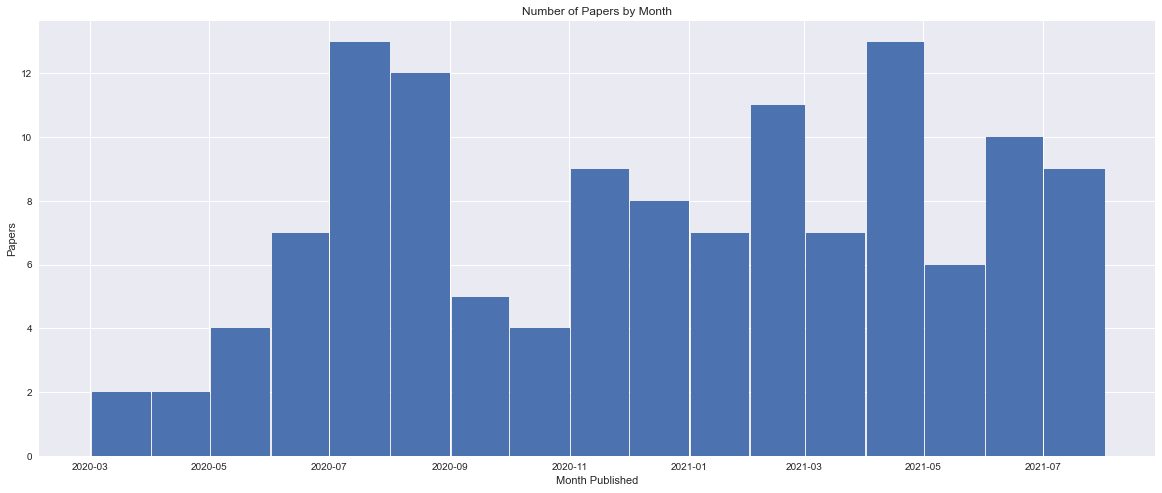

In [35]:
metadata_t = metadata.dropna(subset=["date_published"])
date_published_bins = sorted(list(set([d.replace(day=1) for d in metadata_t["date_published"]])))
plt.hist(metadata_t["date_published"], bins=date_published_bins)
plt.xlabel("Month Published")
plt.ylabel("Papers")
plt.title("Number of Papers by Month")
plt.show()

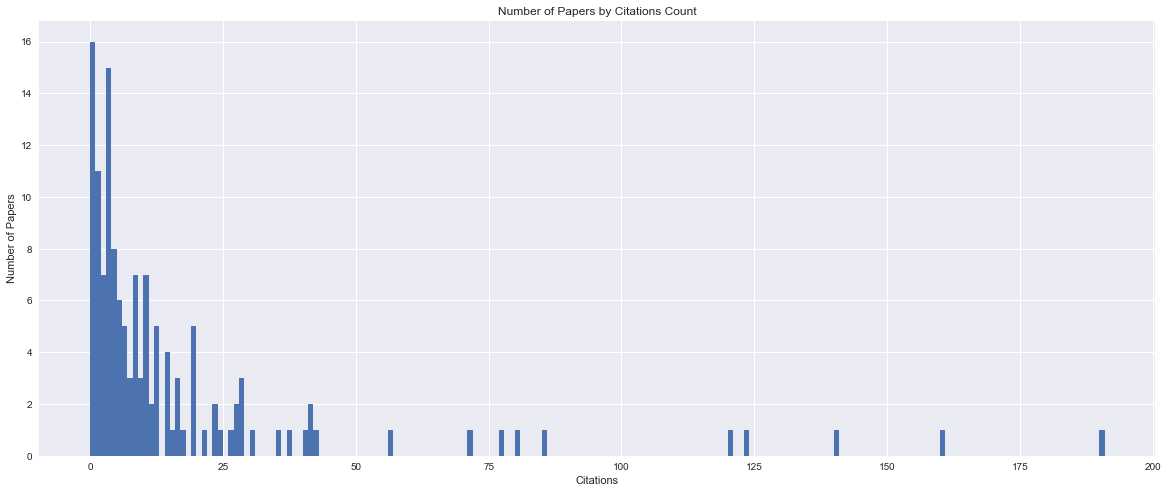

In [36]:
citations = [int(x) for x in metadata.citations if not np.isnan(x)]
plt.hist(citations, bins=range(max(citations)+1))
plt.xlabel("Citations")
plt.ylabel("Number of Papers")
plt.title("Number of Papers by Citations Count")
plt.show()